In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms

In [9]:

def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)) ])

# Download and load the training data
trainset    = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Download and load the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

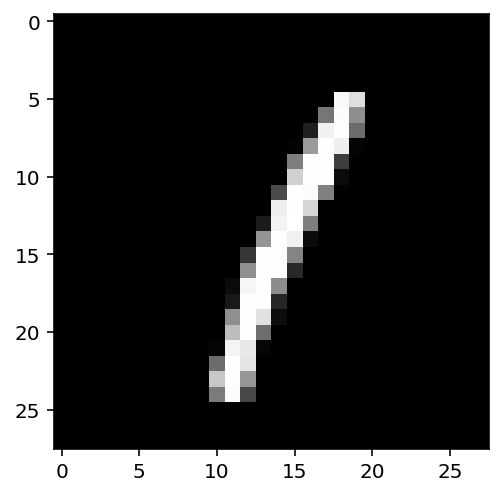

In [12]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [14]:
images.shape

torch.Size([32, 1, 28, 28])

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,5),
            #nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        #self.layer3 = nn.Sequential(
        #    nn.Conv2d(32,64,5),
        #    #nn.BatchNorm2d(),
        #    nn.ReLU(inplace=True),
        #    nn.MaxPool2d(2)
        #            )
        self.fc = nn.Sequential(
            nn.Linear(32 *4 *4,128),
            nn.ReLU(inplace =True),
            nn.Linear(128,64),
            nn.ReLU(inplace=True),
            nn.Linear(64,32),
            nn.Linear(32,10))
    
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        #x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = F.softmax(x, dim=1)

        return x

model = Net()


In [16]:
images, labels = next(iter(trainloader))
y = images.resize_(images.shape[0], 1, 28,28)
ps = model.forward(y)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
#if torch.cuda.is_available():
 #   model = model.cuda()
 #   criterion = criterion.cuda()
print(model)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [19]:
train_loss = []
val_loss = []

epochs = 5
print_every = 50

optimizer = optim.SGD(model.parameters(), lr=0.1)
for e in range(epochs):
    running_loss = 0
    total = 0
    correct = 0
    print(f"Epoch: {e+1}/{epochs}")

    model.train()
    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 1,28,28)
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0
        

    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(iter(testloader)):
            images.resize_(images.size()[0], 1,28,28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network: %d %%' % (
        100 * correct / total))

Epoch: 1/5
	Iteration: 0	 Loss: 0.0465
	Iteration: 50	 Loss: 2.0871
	Iteration: 100	 Loss: 0.8452
	Iteration: 150	 Loss: 0.3761
	Iteration: 200	 Loss: 0.3312
	Iteration: 250	 Loss: 0.2106
	Iteration: 300	 Loss: 0.1714
	Iteration: 350	 Loss: 0.2024
	Iteration: 400	 Loss: 0.1453
	Iteration: 450	 Loss: 0.1464
	Iteration: 500	 Loss: 0.1278
	Iteration: 550	 Loss: 0.1377
	Iteration: 600	 Loss: 0.1076
	Iteration: 650	 Loss: 0.1268
	Iteration: 700	 Loss: 0.0996
	Iteration: 750	 Loss: 0.1040
	Iteration: 800	 Loss: 0.1145
	Iteration: 850	 Loss: 0.1754
	Iteration: 900	 Loss: 0.1150
	Iteration: 950	 Loss: 0.1016
	Iteration: 1000	 Loss: 0.0890
	Iteration: 1050	 Loss: 0.0536
	Iteration: 1100	 Loss: 0.0918
	Iteration: 1150	 Loss: 0.0792
	Iteration: 1200	 Loss: 0.0686
	Iteration: 1250	 Loss: 0.0848
	Iteration: 1300	 Loss: 0.0862
	Iteration: 1350	 Loss: 0.0723
	Iteration: 1400	 Loss: 0.1072
	Iteration: 1450	 Loss: 0.0595
	Iteration: 1500	 Loss: 0.0782
	Iteration: 1550	 Loss: 0.0757
	Iteration: 1600	 Lo

In [ ]:
images, labels = next(iter(testloader))
y =images.resize_(images.shape[0],1, 28,28)

ps = F.softmax(model.forward(y),dim=1)
ps[0,:].shape
#pred = torch.exp(ps)


torch.Size([10])

In [ ]:
y[0].view(1, 28, 28).shape

torch.Size([1, 28, 28])

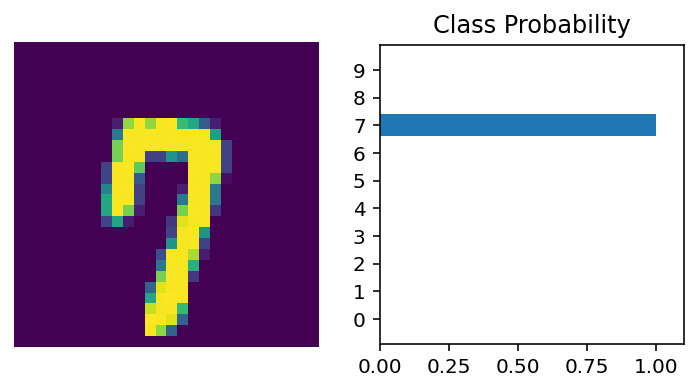

In [ ]:
view_classify(y[4].view(1, 28, 28), ps[4])

In [ ]:
ps[0].argmax()

tensor(8)